In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install "peft==0.2.0"
# !pip install "transformers==4.27.2" "datasets==2.9.0" "accelerate==0.17.1" "evaluate==0.4.0" "bitsandbytes==0.37.1" loralib --upgrade --quiet

#pip install peft transformers datasets accelerate evaluate bitsandbytes loralib --upgrade --quiet
# install additional dependencies needed for training
# !pip install rouge-score tensorboard py7zr

In [3]:
!pip install peft transformers datasets accelerate evaluate bitsandbytes loralib --upgrade --quiet


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install --upgrade torch torchvision torchaudio


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install tensorboard


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
from datasets import load_from_disk, concatenate_datasets, DatasetDict

#textile patent documents
dataset = DatasetDict({
    'train': load_from_disk('../Textile_Patent_(70-20-10)_LexRank_thres_3/train'),
    'validation': load_from_disk('../Textile_Patent_(70-20-10)_LexRank_thres_3/validation'),
    'test': load_from_disk('../Textile_Patent_(70-20-10)_LexRank_thres_3/test')
})
#dataset = load_from_disk('/content/drive/MyDrive/FYP-Abstractive Text Summarization/Data/Textile_Patent_(70-20-10)_LexRank')

In [7]:
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Validation dataset size: {len(dataset['validation'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 7905
Validation dataset size: 1130
Test dataset size: 2259


In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id="facebook/bart-large"

# Load tokenizer of bart-large
tokenizer = AutoTokenizer.from_pretrained(model_id)
#model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [9]:
#len(dataset["train"]['description'][4])
# min_len = 9999999
# for i in range(len(dataset['train'])):
#   temp = len(dataset["train"]['description'][i])
#   if (temp < min_len):
#     min_len = temp

# print(min_len)

In [10]:
# from datasets import concatenate_datasets
# import numpy as np
# # The maximum total input sequence length after tokenization.
# # Sequences longer than this will be truncated, sequences shorter will be padded.
# tokenized_inputs = dataset["train"].map(lambda x: tokenizer(x["description"], truncation=True), batched=True, remove_columns=["description", "abstract"])
# input_lenghts = [len(x) for x in tokenized_inputs["input_ids"]]
# # take 85 percentile of max length for better utilization
# max_source_length = int(np.percentile(input_lenghts, 85))
# print(f"Max source length: {max_source_length}")

# # The maximum total sequence length for target text after tokenization.
# # Sequences longer than this will be truncated, sequences shorter will be padded."
# tokenized_targets = dataset["train"].map(lambda x: tokenizer(x["abstract"], truncation=True), batched=True, remove_columns=["description", "abstract"])
# target_lenghts = [len(x) for x in tokenized_targets["input_ids"]]
# # take 90 percentile of max length for better utilization
# max_target_length = int(np.percentile(target_lenghts, 90))
# print(f"Max target length: {max_target_length}")

In [11]:
#Maximum available for bart model
max_source_length = 1024
max_target_length = 512

In [12]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for bart
    #inputs = ["summarize: " + extract_important_sentences(item) for item in sample["description"]]
    inputs = ["summarize: " + item for item in sample["description"]]


    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["abstract"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [13]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["description", "abstract"])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [14]:
# # save datasets to disk for later easy loading
# tokenized_dataset["train"].save_to_disk("../Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT4_M2L/train")
# tokenized_dataset["validation"].save_to_disk("../Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT4_M2L/validation")
# tokenized_dataset["test"].save_to_disk("../Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT4_M2L/test")

In [15]:
# # Load datasets
# tokenized_dataset = DatasetDict({
#     'train': load_from_disk('/content/drive/MyDrive/FYP-Abstractive Text Summarization/Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT3/train'),
#     'validation': load_from_disk('/content/drive/MyDrive/FYP-Abstractive Text Summarization/Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT3/validation'),
#     'test': load_from_disk('/content/drive/MyDrive/FYP-Abstractive Text Summarization/Adapter_Tuning/LoRA+Bart/tokenized_data_S2_EXT3/test')
# })

In [16]:
# tokenized_data = {
#     'train': train,
#     'validation': valid,
#     'test': test
# }

In [17]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7905
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1130
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2259
    })
})

In [18]:
from transformers import AutoModelForSeq2SeqLM

# huggingface hub model id
model_id = "facebook/bart-large"

# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [19]:
# !pip list | grep cuda

In [20]:
print(model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

In [21]:
# import torch
# #check for gpu
# if torch.backends.mps.is_available():
#    mps_device = torch.device("mps")
#    x = torch.ones(1, device=mps_device)
#    print (x)
# else:
#    print ("MPS device not found.")

In [22]:
import platform
print(platform.platform())

Linux-5.15.0-89-generic-x86_64-with-glibc2.35


In [23]:
from peft import LoraConfig
from peft import get_peft_model
from peft import prepare_model_for_kbit_training
from peft import TaskType
# Define LoRA Config
lora_config = LoraConfig(
 r=16,
 lora_alpha=32,
 target_modules=["q_proj", "k_proj", "v_proj"],
 lora_dropout=0.05,
 bias="none",
 init_lora_weights="gaussian",
 task_type=TaskType.SEQ_2_SEQ_LM
)
# prepare int-8 model for training
model = prepare_model_for_kbit_training(model)

# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,538,944 || all params: 409,830,400 || trainable%: 0.863514273221313


In [24]:
from transformers import DataCollatorForSeq2Seq

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [25]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback

output_dir="../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT4_EXP16"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    learning_rate=1e-4, 
    num_train_epochs=100,
    logging_dir=f"{output_dir}/logs",
    logging_strategy="epoch",
    evaluation_strategy = "epoch",
    save_total_limit = 10,
    #logging_steps=500,
    # eval_steps=500,
    save_strategy="epoch",
    report_to="tensorboard",
    load_best_model_at_end = True,
    metric_for_best_model = 'loss'
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    callbacks = [EarlyStoppingCallback(early_stopping_patience=7)]
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
# device = torch.device("mps:0")
# model.to(device)

In [27]:
print(model)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): BartForConditionalGeneration(
      (model): BartModel(
        (shared): Embedding(50265, 1024, padding_idx=1)
        (encoder): BartEncoder(
          (embed_tokens): Embedding(50265, 1024, padding_idx=1)
          (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
          (layers): ModuleList(
            (0-11): 12 x BartEncoderLayer(
              (self_attn): BartSdpaAttention(
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=1024, bias=False)
            

In [ ]:
# train model
trainer.train()

In [29]:
# Save our LoRA model & tokenizer results
peft_model_id="M2L_LR_S2_EXT3_EXP16"
trainer.model.save_pretrained(f'../Adapter_Tuning/LoRA+Bart/{peft_model_id}_model')
tokenizer.save_pretrained(f'../Adapter_Tuning/LoRA+Bart/{peft_model_id}_tokenizer')
# if you want to save the base model to call
# trainer.model.base_model.save_pretrained(peft_model_id)

('../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/tokenizer_config.json',
 '../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/special_tokens_map.json',
 '../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/vocab.json',
 '../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/merges.txt',
 '../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/added_tokens.json',
 '../Adapter_Tuning/LoRA+Bart/M2L_LR_S2_EXT3_EXP16_tokenizer/tokenizer.json')

In [30]:
history = trainer.state.log_history[:len(trainer.state.log_history)-1]
training_loss = []
eval_loss = []
for i in range(len(history)):
    if i%2 == 0:
        training_loss.append(history[i]['loss'])
    else:
        eval_loss.append(history[i]['eval_loss'])

In [31]:
epochs = range(1, len(training_loss) + 1)

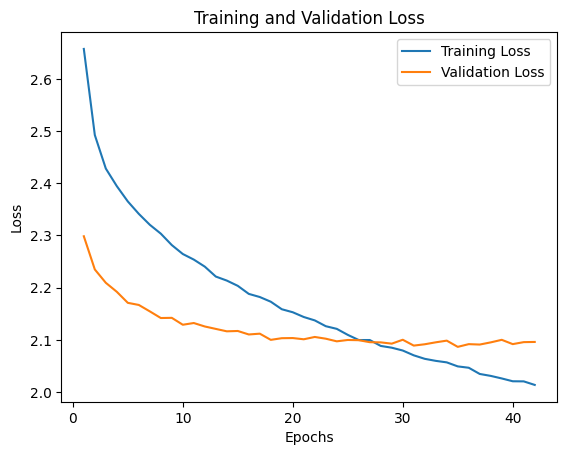

In [34]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show plot
plt.show()

In [ ]:
test_dataset = load_from_disk("/content/drive/MyDrive/FYP-Abstractive Text Summarization/Adapter_Tuning/LoRA+T5/tokenized_data/test").with_format("torch")

In [ ]:
for sample in test_dataset:
 input = tokenizer.decode(sample['input_ids'].detach().cpu().numpy(), skip_special_tokens=True)
 output = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(), do_sample=True, top_p=0.9, max_new_tokens=max_target_length)
 prediction = tokenizer.decode(output[0].detach().cpu().numpy(), skip_special_tokens=True)
 break

In [ ]:
input

'summarize: CROSS-REFERENCE TO RELATED APPLICATIONS The present application claims priority from Australian Provisional Patent Application No 2006903417 filed on 26 Jun. 2006, the content of which is incorporated herein by reference. INTRODUCTION TO THE INVENTION This invention relates to the packaging of consumer products and relates particularly to products that are formed of pulp material, particularly pulp material formed of waste paper, waste timber, waste fabric material, virgin timber and other similar pulp material. The invention more particularly relates to high quality products carrying high definition printing or other decoration. BACKGROUND TO THE INVENTION The creation of compelling and high quality packaging for consumer durables is well established and is executed in a variety of forms and formats known in the prior art but with each of the prior art, the formats and methodologies having their own particular limitations. The consumer market demands increasing colour, vib

In [ ]:
prediction

'The present invention relates to product packaging which comprises high quality products carrying high definition printing and/or other similar products in the manufacture and/or any product that is able to be recycled.'